In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

In [2]:
DATADIR = r"D:\Projects\MS Projects\sketches-recognitin\Alzheimer_s Dataset\train"
CATEGORIES = ['MildDemented', 'ModerateDemented','NonDemented','VeryMildDemented']
IMG_SIZE=224

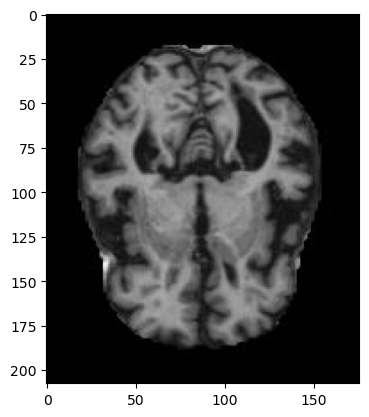

In [3]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [4]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data() 

In [5]:
print(len(training_data))

5121


In [6]:
lenofimage = len(training_data)

In [7]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

In [10]:
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols)

In [11]:
X = X.reshape(X.shape[0], img_rows, img_cols,3)

In [12]:
X.shape

(5121, 224, 224, 3)

In [13]:
X = X/255.0

In [14]:
y=np.array(y)

In [15]:
y.shape

(5121,)

In [16]:
SEED = 42
from sklearn.model_selection import train_test_split
import random
random.seed(SEED)
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(X,y, test_size=0.5, random_state=SEED)

In [17]:
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))
import warnings
warnings.filterwarnings("ignore")
from keras.optimizers import SGD

In [18]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
testY = lb.transform(testY)         # transform = perform the one-hot encoding (unique class labels already found)

In [19]:
testY

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [20]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization

In [21]:
img_height = 28
img_width = 28
img_channels = 3

In [23]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Compile model
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
#model = create_cnn((28,28,3),4)

In [25]:
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout': [0.2, 0.3, 0.4]
}


In [26]:
#model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#grid_result = grid.fit(trainX, trainY)

#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [27]:
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001, epsilon=1e-08, decay=0.01)
import keras.backend as K
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                   specificity,conditional_average_metric ,sensitivity,F1_Score,'accuracy','top_k_categorical_accuracy']

In [28]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 120
 
# compile the model using SGD as our optimizer and categorical cross-entropy loss
# (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
#opt = SGD(lr=INIT_LR)   # Stochastic Gradient Descent (SGD) optimizer
#model = create_model(10)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=metrics)

[INFO] training network...


In [29]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

In [30]:
from keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [31]:
train_generator = datagen.flow(trainX, trainY, batch_size=32)

In [32]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


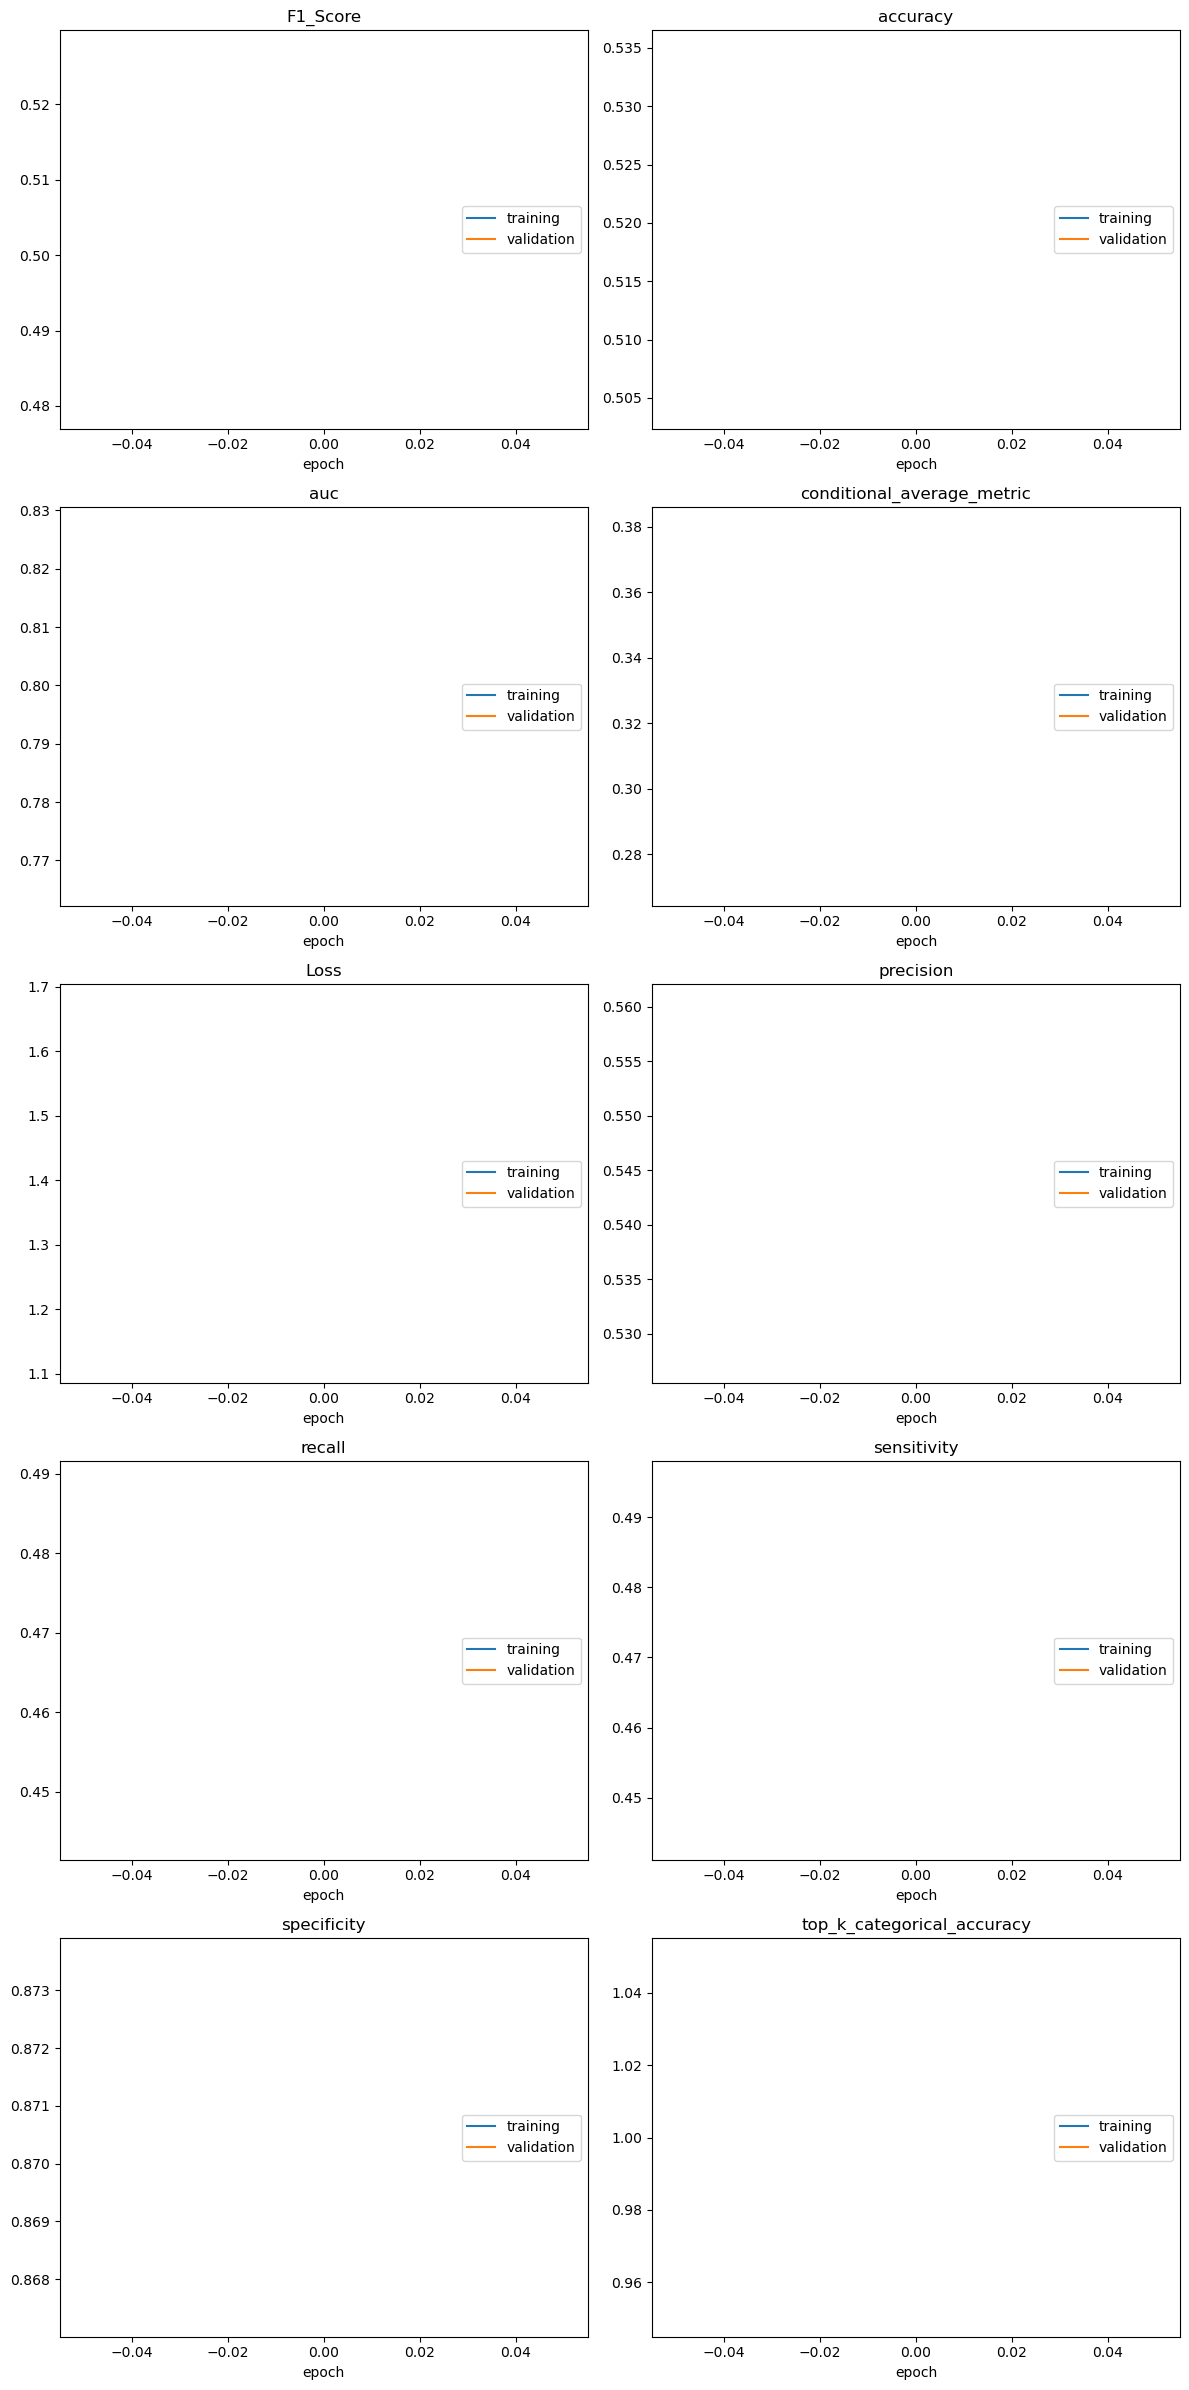

F1_Score
	training         	 (min:    0.479, max:    0.479, cur:    0.479)
	validation       	 (min:    0.527, max:    0.527, cur:    0.527)
accuracy
	training         	 (min:    0.504, max:    0.504, cur:    0.504)
	validation       	 (min:    0.535, max:    0.535, cur:    0.535)
auc
	training         	 (min:    0.765, max:    0.765, cur:    0.765)
	validation       	 (min:    0.827, max:    0.827, cur:    0.827)
conditional_average_metric
	training         	 (min:    0.270, max:    0.270, cur:    0.270)
	validation       	 (min:    0.380, max:    0.380, cur:    0.380)
Loss
	training         	 (min:    1.676, max:    1.676, cur:    1.676)
	validation       	 (min:    1.114, max:    1.114, cur:    1.114)
precision
	training         	 (min:    0.527, max:    0.527, cur:    0.527)
	validation       	 (min:    0.560, max:    0.560, cur:    0.560)
recall
	training         	 (min:    0.444, max:    0.444, cur:    0.444)
	validation       	 (min:    0.489, max:    0.489, cur:    0.489)
sensi

In [ ]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken
H = model.fit(train_generator, validation_data=(testX, testY), epochs=90, batch_size=32,callbacks = [plot_loss_1,early_stop])
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

In [ ]:
y2 = model.predict(testX)
print(y2)

In [ ]:
# evaluate the network
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=CATEGORIES))

In [ ]:
testY

In [ ]:
y_pred=np.argmax(y2, axis=1)
y_test=np.argmax(testY, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='2.0f')

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y_pred)*100,"on 100 epochs")